In [48]:
import json
import requests
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

from tokens import TOKEN_KEY, TOKEN_CX

In [1]:
def get_google_search_results(string, siteSearch="", searchType="exact", page=0, hl="pt-BR", lr="lang_pt"):
    url = f'https://customsearch.googleapis.com/customsearch/v1'
    params = {
        "key": TOKEN_KEY,
        "cx": TOKEN_CX,
        "hl": hl,
        "lr": lr,
        "start": (page*10+1)
    }

    # Fill params according to search type. 'exact' uses 'exactTerms' and 'any' uses 'q',
    # which in theory uses results that do not have the exact phrasing as in the string
    if searchType == "exact":
        params["exactTerms"] = string
    elif searchType == "any":
        params["q"] = string
    else:
        raise Exception("Invalid search type")

    # If siteSearch is not empty, search only in the specified site
    if siteSearch:
        params["siteSearch"] = siteSearch
        params["siteSearchFilter"] = "i"

    # Make request
    response = requests.get(url, params=params).json()

    # Get total number of results if the request was successful
    try:
        total_results = response['searchInformation']['totalResults']
    except:
        print(params)
        print(response)
        raise Exception("Erro na requisição")

    return response, int(total_results)

In [2]:
def get_count_from_file(filepath):
    with open(filepath, "rb") as f:
        data = pickle.load(f)

    counts = []
    for k in data:
        counts.append([c for _, c in k])

    return np.array(counts)

In [3]:
def plot_file(filename):
    with open(filename, "rb") as f:
        data = pickle.load(f)

    counts = []
    for k in data:
        counts.append([c for _, c in k])
    counts = np.array(counts)
    count = np.mean(counts, axis=1)

    plt.figure(figsize=(8, 4))
    plt.bar(range(len(count)), count, color="#7ed9fc")
    plt.fill_between(range(len(count)), count - np.std(counts, axis=1), count + np.std(counts, axis=1), color="black", linestyle="--", alpha=0.5)
    plt.plot(range(len(count)), count, color="black")
    plt.ylim(0, 1.2 * max(count[3:]))
    plt.title(filename)
    plt.yticks([])
    # plt.yscale('log')
    plt.show()

In [4]:
def display_snippets(filename, pos=0):
    with open(filename, "rb") as f:
        data = pickle.load(f)

    for i, r in enumerate(data):
        m = r[0][0]['items'][pos]
        print(f"-" * 50)
        print(f"qt: {i+1}, total: {r[0][0]['searchInformation']['totalResults']}")
        print(m['title'])
        print("\t", m['snippet'])

In [107]:
def download_ks(laugh_atom='k', start=1, end=25, siteSearch="", searchType="exact", hl="pt-BR", lr="lang_pt", filepath_name="data_requests", simulations=1):
    all_data = []

    for i in range(start, end+1):
        data = []
        string = laugh_atom * i
        print(f"[{i} / {end}] Processing {string}...")

        for j in range(simulations):
            print(f"  [{j + 1} / {simulations}] Making request for {string}...")
            response, total_results = get_google_search_results(string, siteSearch=siteSearch, searchType=searchType, hl=hl, lr=lr)
            data.append((response, total_results))

        all_data.append(data)

        with open(filepath_name + ".pkl", "wb") as f:
            pickle.dump(all_data, f)

        with open(filepath_name + "_count.json", "w") as f:
            count = get_count_from_file(filepath_name + ".pkl")
            json.dump(count, f, indent=4)

        with open(filepath_name + "_texts.json", "w") as f:
            texts = [[d['link'] for d in k[0][0]['items']] for k in all_data]
            json.dump(texts, f, indent=4)

In [5]:
def download_results(laugh_atom='k', start=1, end=25, siteSearch="", searchType="exact", filepath="data_requests.pkl", pages=1):
    output = []

    for i in range(start, end+1):
        string = laugh_atom * i
        print(f"[{i} / {end}] Processing {string}...")

        responses = []
        for j in range(pages):
            print(f"  [{j + 1} / {pages}] Making request for {string}...")
            response, total_results = get_google_search_results(string, siteSearch=siteSearch, searchType=searchType, page=j)
            if 'items' in response:
                responses.append(response)

        links = [r['link'] for response in responses for r in response['items']]
        output.append(links)

        with open(filepath, "w") as f:
            json.dump(output, f, indent=4)

[1 / 50] Processing k...
  [1 / 2] Making request for k...
  [2 / 2] Making request for k...
[2 / 50] Processing kk...
  [1 / 2] Making request for kk...
  [2 / 2] Making request for kk...
[3 / 50] Processing kkk...
  [1 / 2] Making request for kkk...
  [2 / 2] Making request for kkk...
[4 / 50] Processing kkkk...
  [1 / 2] Making request for kkkk...
  [2 / 2] Making request for kkkk...
[5 / 50] Processing kkkkk...
  [1 / 2] Making request for kkkkk...
  [2 / 2] Making request for kkkkk...
[6 / 50] Processing kkkkkk...
  [1 / 2] Making request for kkkkkk...
  [2 / 2] Making request for kkkkkk...
[7 / 50] Processing kkkkkkk...
  [1 / 2] Making request for kkkkkkk...
  [2 / 2] Making request for kkkkkkk...
[8 / 50] Processing kkkkkkkk...
  [1 / 2] Making request for kkkkkkkk...
  [2 / 2] Making request for kkkkkkkk...
[9 / 50] Processing kkkkkkkkk...
  [1 / 2] Making request for kkkkkkkkk...
  [2 / 2] Making request for kkkkkkkkk...
[10 / 50] Processing kkkkkkkkkk...
  [1 / 2] Making req

In [5]:
download_results(start=35, end=50, siteSearch="twitter.com", searchType="exact", filepath="twitter_21-35_2page_links.json", pages=2)

In [ ]:
download_results(start=1, end=25, siteSearch="twitter.com", searchType="exact", filepath="twitter_21-35_2page_links.json", pages=2)

In [59]:
download_ks(start=35, end=70, siteSearch="twitter.com", searchType="exact", filepath="twitter_35-70_simul2.json", simulations=2)

[35 / 70] Processing kkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkk...
  [1 / 2] Making request for kkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkk...
  [2 / 2] Making request for kkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkk...
[36 / 70] Processing kkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkk...
  [1 / 2] Making request for kkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkk...
  [2 / 2] Making request for kkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkk...
[37 / 70] Processing kkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkk...
  [1 / 2] Making request for kkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkk...
  [2 / 2] Making request for kkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkk...
[38 / 70] Processing kkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkk...
  [1 / 2] Making request for kkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkk...
  [2 / 2] Making request for kkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkk...
[39 / 70] Processing kkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkk...
  [1 / 2] Making request for kkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkk...
  [2 / 2] Making request for kkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkk

In [109]:
download_ks(laugh_atom="ja", start=1, end=25, siteSearch="twitter.com",
            searchType="exact", filepath="twitter_1-25_ja_2simul.pkl", simulations=2,
            hl="es", lr="lang_es")

[1 / 25] Processing ja...
  [1 / 2] Making request for ja...
  [2 / 2] Making request for ja...
[2 / 25] Processing jaja...
  [1 / 2] Making request for jaja...
  [2 / 2] Making request for jaja...
[3 / 25] Processing jajaja...
  [1 / 2] Making request for jajaja...
  [2 / 2] Making request for jajaja...
[4 / 25] Processing jajajaja...
  [1 / 2] Making request for jajajaja...
  [2 / 2] Making request for jajajaja...
[5 / 25] Processing jajajajaja...
  [1 / 2] Making request for jajajajaja...
  [2 / 2] Making request for jajajajaja...
[6 / 25] Processing jajajajajaja...
  [1 / 2] Making request for jajajajajaja...
  [2 / 2] Making request for jajajajajaja...
[7 / 25] Processing jajajajajajaja...
  [1 / 2] Making request for jajajajajajaja...
  [2 / 2] Making request for jajajajajajaja...
[8 / 25] Processing jajajajajajajaja...
  [1 / 2] Making request for jajajajajajajaja...
  [2 / 2] Making request for jajajajajajajaja...
[9 / 25] Processing jajajajajajajajaja...
  [1 / 2] Making reque

In [112]:
download_ks(laugh_atom="w", start=1, end=25, siteSearch="twitter.com",
            searchType="exact", filepath="twitter_1-25_w_2simul.pkl", simulations=2,
            hl="jp", lr="lang_jp")

[1 / 25] Processing w...
  [1 / 2] Making request for w...
  [2 / 2] Making request for w...
[2 / 25] Processing ww...
  [1 / 2] Making request for ww...
  [2 / 2] Making request for ww...
[3 / 25] Processing www...
  [1 / 2] Making request for www...
  [2 / 2] Making request for www...
[4 / 25] Processing wwww...
  [1 / 2] Making request for wwww...
  [2 / 2] Making request for wwww...
[5 / 25] Processing wwwww...
  [1 / 2] Making request for wwwww...
  [2 / 2] Making request for wwwww...
[6 / 25] Processing wwwwww...
  [1 / 2] Making request for wwwwww...
  [2 / 2] Making request for wwwwww...
[7 / 25] Processing wwwwwww...
  [1 / 2] Making request for wwwwwww...
  [2 / 2] Making request for wwwwwww...
[8 / 25] Processing wwwwwwww...
  [1 / 2] Making request for wwwwwwww...
  [2 / 2] Making request for wwwwwwww...
[9 / 25] Processing wwwwwwwww...
  [1 / 2] Making request for wwwwwwwww...
  [2 / 2] Making request for wwwwwwwww...
[10 / 25] Processing wwwwwwwwww...
  [1 / 2] Making req

In [16]:
with open("silvia_twitter_1-10_10simul.pkl", "rb") as f:
    data = pickle.load(f)

counts = []
for k in data:
    counts.append([c for _, c in k])
counts = np.array(counts)
print(np.mean(counts, axis=1))
print(np.std(counts, axis=1))

[15090000.   247800.   499000.   639400.   675300.   659400.   407400.
   361300.   267800.   292300.]
[2177360.78774281   18159.29514051   36742.34614175   51357.95946102
   88600.28216659   50947.42387992   92126.21776671   12900.
    6400.            8100.        ]


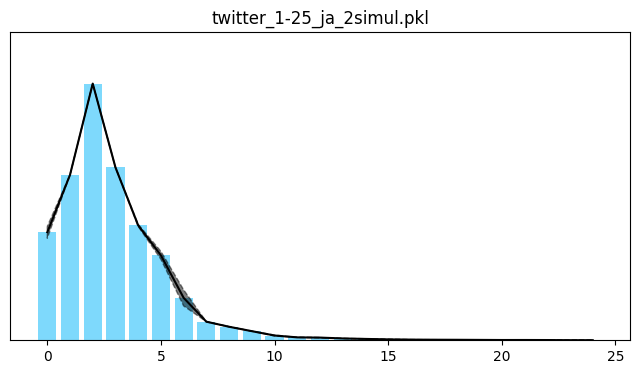

In [111]:
plot_file("twitter_1-25_ja_2simul.pkl")

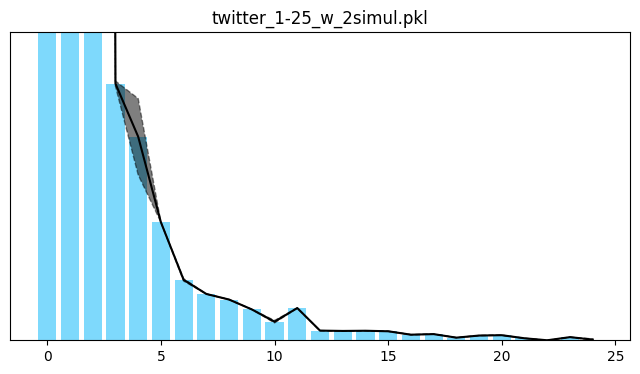

In [115]:
plot_file("twitter_1-25_w_2simul.pkl")

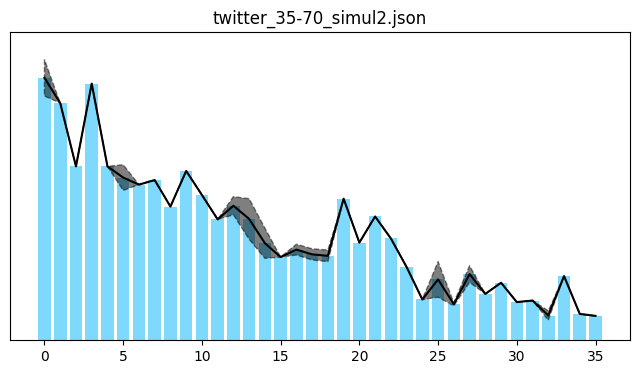

In [66]:
plot_file("twitter_35-70_simul2.json")

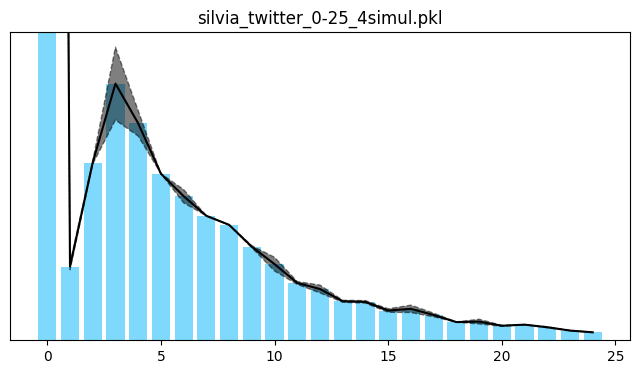

In [72]:
plot_file("silvia_twitter_0-25_4simul.pkl")

In [21]:
display_snippets("silvia_youtube_0-25_4simul.pkl", pos=5)

--------------------------------------------------
qt: 1, total: 95100000
Marshmello, Tropkillaz, TMJ - Vem K Me Da (Visualizer) - YouTube
	 15 de jun. de 2023 ... Marshmello, Tropkillaz, TMJ - Vem K Me Da (Visualizer). Tropkillaz. Tropkillaz. 823K subscribers. Subscribe. <__slot-el>. Subscribed.
--------------------------------------------------
qt: 2, total: 185000
KK NDONGO LUMA - YouTube
	 14 de jul. de 2022 ... KK NDONGO LUMA. Fiche Pro. Fiche Pro. 21.7K subscribers. Subscribe. <__slot-el>. Subscribed. 1.8K. I like this. I dislike this.
--------------------------------------------------
qt: 3, total: 271000
Essa aí veio do fundo do baú kkk Nossa parceria com o embaixador ...
	 13 de jul. de 2023 ... Essa aí veio do fundo do baú kkk Nossa parceria com o embaixador é de longa data #shorts · Matheus e Kauan. Matheus e Kauan.
--------------------------------------------------
qt: 4, total: 273000
Não é que funcionou? kkkk #shorts - YouTube
	 17 de abr. de 2022 ... Não é que funcionou?

# Making final visualization

In [67]:
np.mean(get_count_from_file("twitter_35-70_simul2.json"), axis=1)

array([6340. , 5730. , 4200. , 6200. , 4200. , 3930. , 3760. , 3870. ,
       3230. , 4090. , 3510. , 2920. , 3250. , 2930. , 2345. , 2010. ,
       2190. , 2075. , 2040. , 3420. , 2360. , 2990. , 2460. , 1770. ,
        985.5, 1470. ,  870.5, 1600. , 1120. , 1390. ,  922. ,  960. ,
        598.5, 1550. ,  636.5,  589. ])

In [125]:
with open("twitter_1-25_ja_2simul.pkl", "rb") as f:
    data = pickle.load(f)
    with open("twitter_1-25_ja_texts.json", "w") as f2:
        texts = [[d['link'] for d in k[0][0]['items']] for k in data]
        json.dump(texts, f2, indent=4)
    with open("twitter_1-25_ja_count.json", "w") as f2:
        count = np.mean(get_count_from_file("twitter_1-25_ja_2simul.pkl"), axis=1)
        json.dump(list(count), f2, indent=4)

In [8]:
counts1 = get_count_from_file("silvia_twitter_0-25_4simul.pkl")
counts2 = get_count_from_file("silvia_twitter_24-34_5simul.pkl")
# counts = np.concatenate((counts1, counts2), axis=1)
counts = np.concatenate((np.mean(counts1, axis=1), np.mean(counts2, axis=1)))
list(counts)

[8790000.0,
 180000.0,
 434250.0,
 627000.0,
 530000.0,
 407000.0,
 352000.0,
 304000.0,
 282000.0,
 228500.0,
 186000.0,
 140000.0,
 125250.0,
 95300.0,
 93800.0,
 72650.0,
 76800.0,
 61825.0,
 44450.0,
 45650.0,
 35450.0,
 38200.0,
 31825.0,
 23700.0,
 19450.0,
 27760.0,
 27700.0,
 29960.0,
 17840.0,
 17740.0,
 16560.0,
 11840.0,
 12740.0,
 9268.0,
 9156.0,
 9148.0]

In [10]:
import json
with open("silvia_twitter_0-34_9simul.json", "w") as f:
    json.dump(list(counts), f)

In [12]:
with open("silvia_twitter_0-25_4simul.pkl", "rb") as f:
    data = pickle.load(f)
with open("silvia_twitter_24-34_5simul.pkl", "rb") as f:
    data2 = pickle.load(f)

with open("silvia_twitter_0-25_4simul_texts.json", "w") as f:
    json.dump(data, f)
with open("silvia_twitter_24-34_5simul_texts.json", "w") as f:
    json.dump(data2, f)

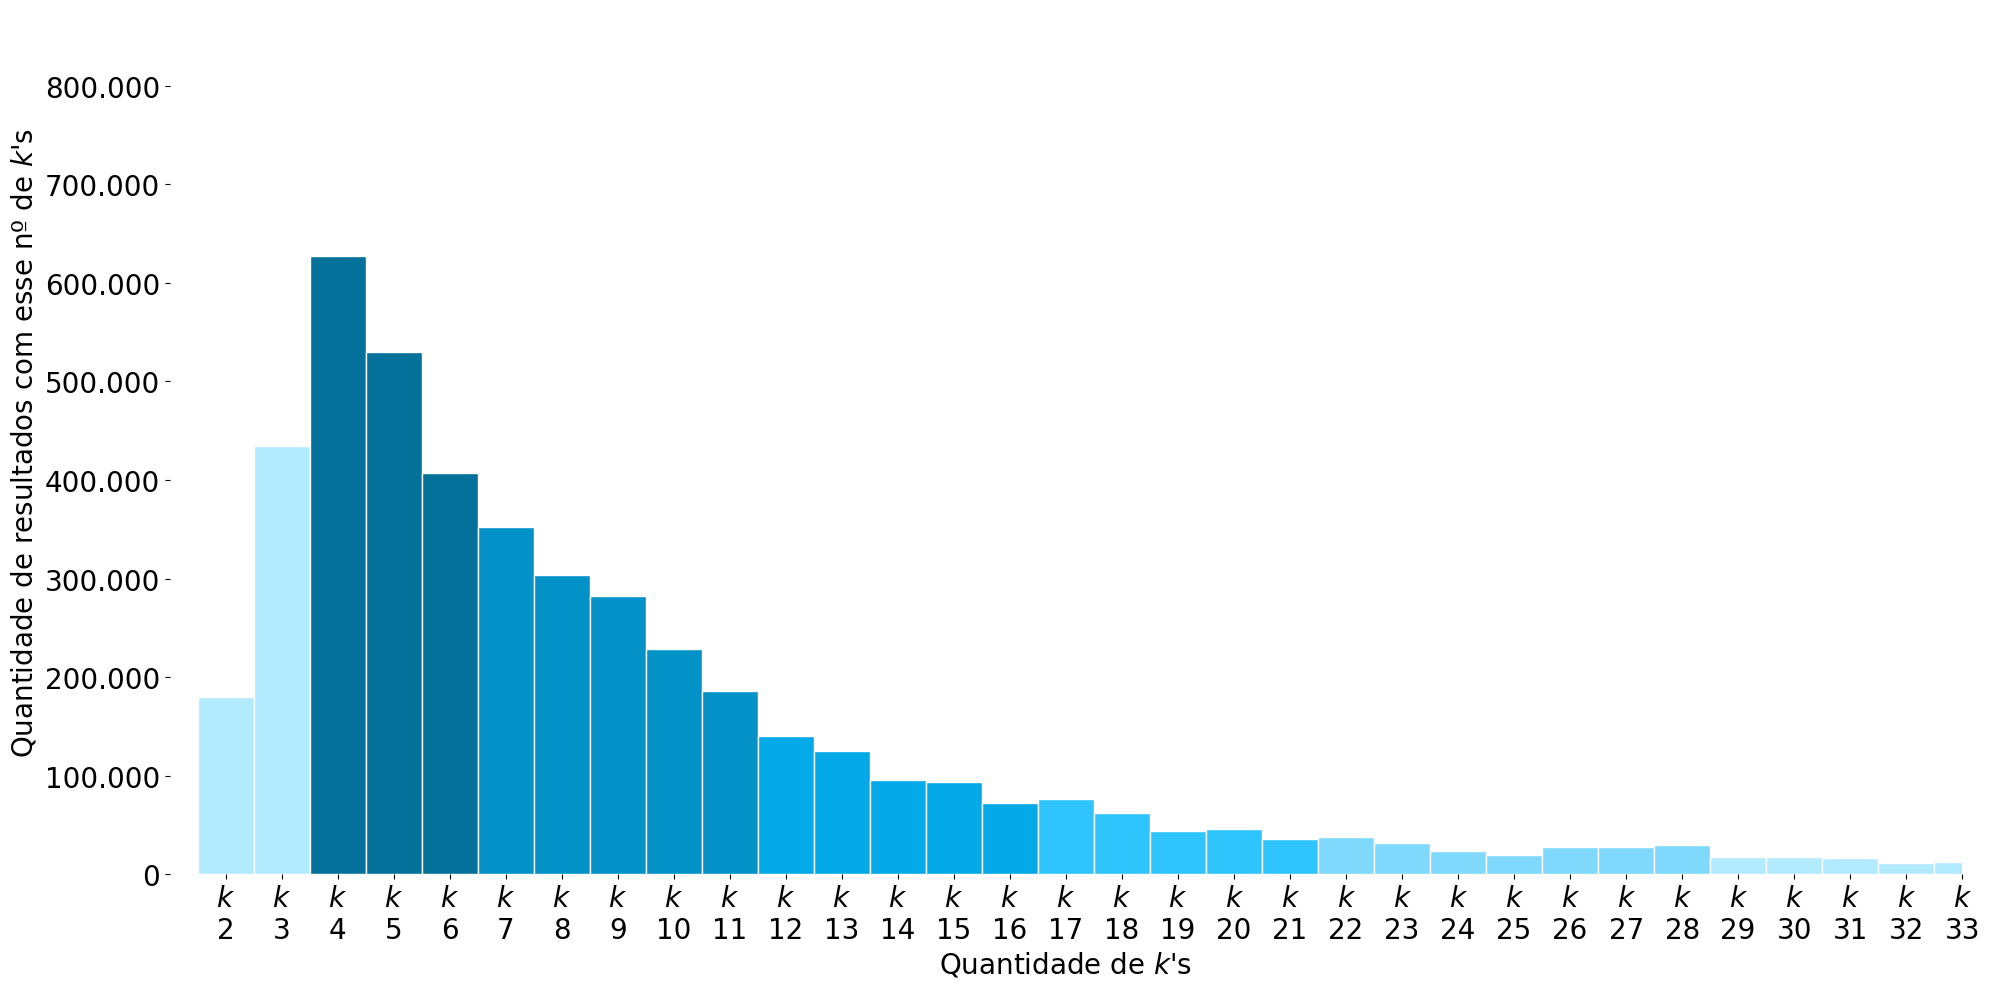

In [134]:
offset = 1

y = counts[1:]
x = [str(k+offset+1) for k, _ in enumerate(y)]

colors = ["#b2eaff"] * 2 + ["#03719a"] * 3 + ["#0492c8"] * 5 + ["#04a9e8"] * 5 + ["#30c4fc"] * 5 + ["#7ed9fc"] * 7 + ["#b2eaff"] * 5

plt.figure(figsize=(20, 10))
plt.bar(x, y, edgecolor='white', linewidth=1, color=colors, width=1)

ax = plt.gca()
ax.set_facecolor('white')
ax.tick_params(axis='both', which='major', labelsize=20)
ax.yaxis.offsetText.set_fontsize(0)

ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',').replace(",", ".")))

plt.grid(False)
plt.xticks(ticks=x, labels=['$\it{k}$\n' + str(s) for s in x])
for spine in plt.gca().spines.values():
    spine.set_visible(False)

# plt.title(title, fontsize=30)
plt.ylabel("Quantidade de resultados com esse nº de $\it{k}$'s", fontsize=20)
plt.xlabel("Quantidade de $\it{k}$'s", fontsize=20)
plt.ylim(0, 1.4 * max(y[1:]))
plt.xlim(-1, 31)
plt.tight_layout()
plt.savefig(f"twitter_orig.png", dpi=100)
plt.show()

In [92]:
def plot_file_2(filename, title, output_filename="tmp", color="#7ed9fc", offset=1):
    counts = get_count_from_file(filename)

    y = np.mean(counts[offset:], axis=1)
    x = [str(k+offset+1) for k, _ in enumerate(y)]

    plt.figure(figsize=(20, 10))
    plt.bar(x, y, edgecolor='white', linewidth=1, color=color, width=1)

    ax = plt.gca()
    ax.set_facecolor('white')
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.yaxis.offsetText.set_fontsize(0)

    ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',').replace(",", ".")))

    plt.grid(False)
    plt.xticks(ticks=x, labels=['$\it{k}$\n' + str(s) for s in x])
    for spine in plt.gca().spines.values():
        spine.set_visible(False)

    plt.title(title, fontsize=30)
    plt.ylabel("Quantidade de resultados com esse nº de $\it{k}$'s", fontsize=20)
    plt.xlabel("Quantidade de $\it{k}$'s", fontsize=20)
    plt.ylim(0, 1.2 * max(y[1:]))
    plt.xlim(-1, 25)
    plt.tight_layout()
    plt.savefig(f"{output_filename}.png", dpi=300)
    plt.show()

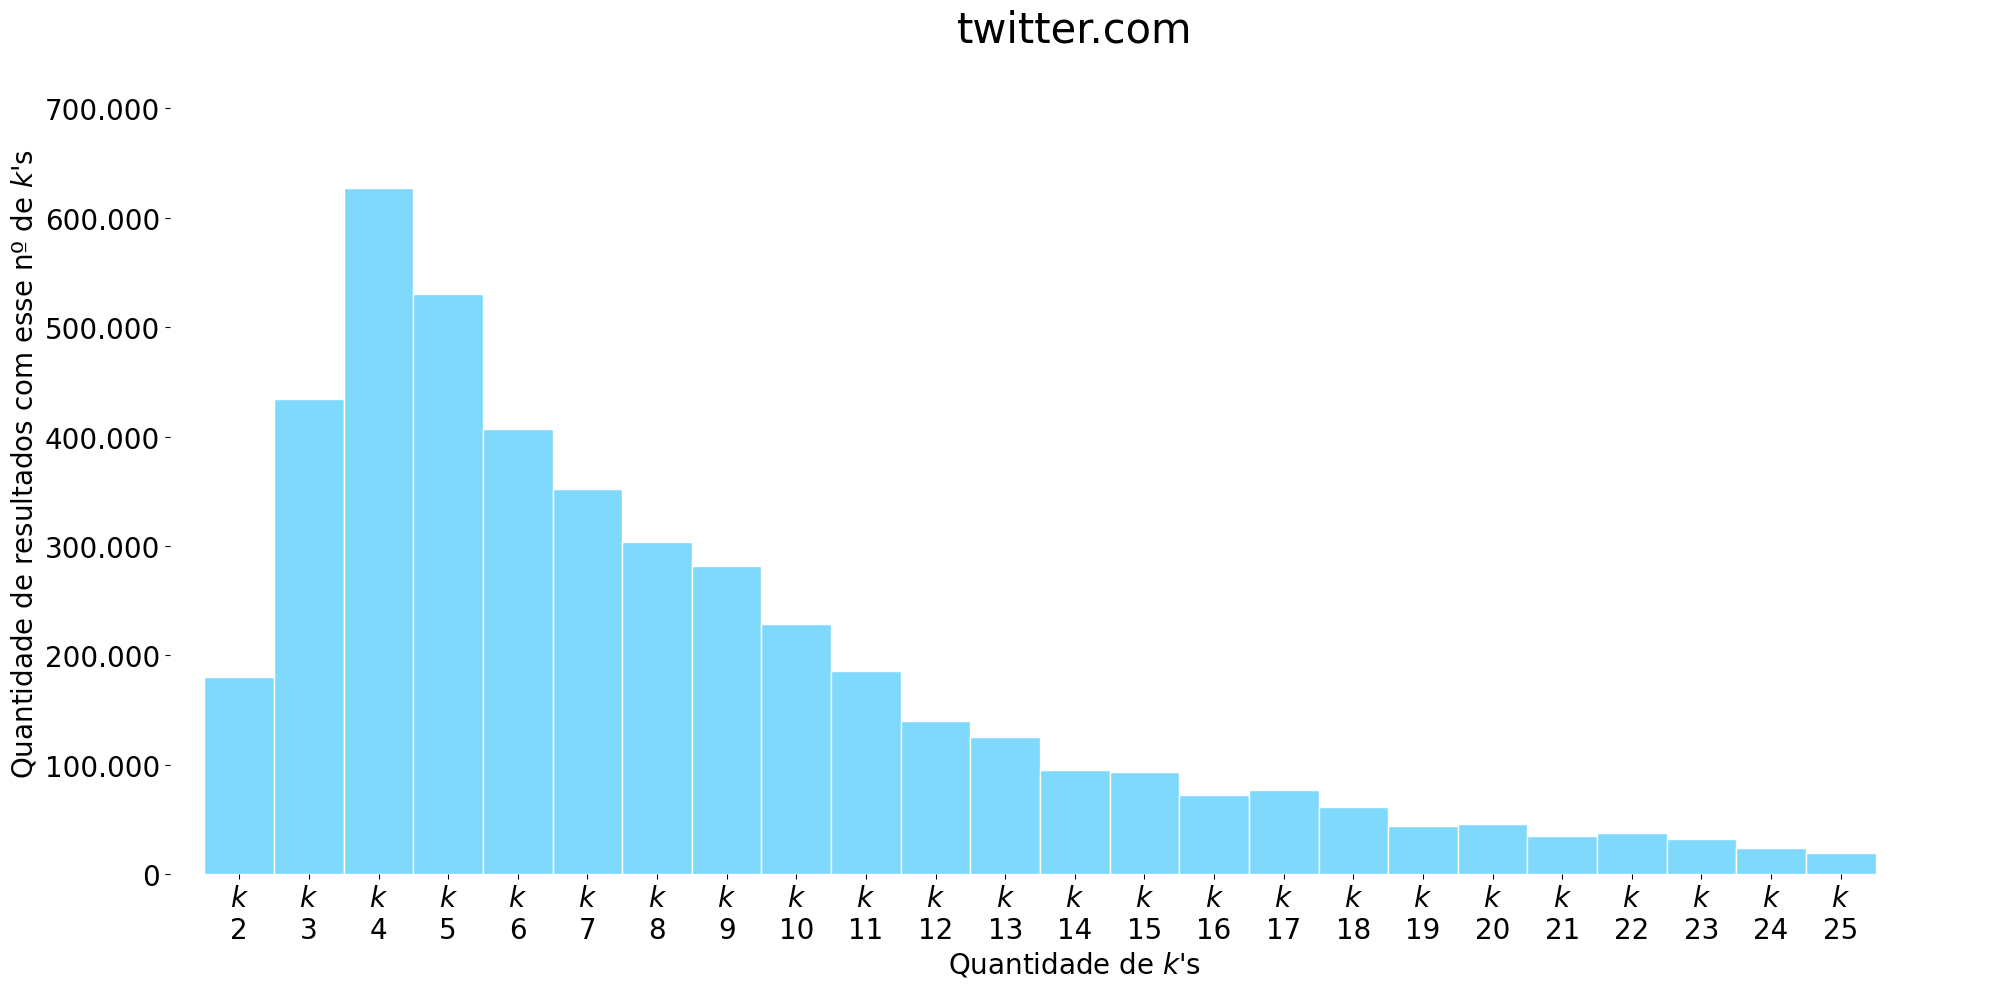

In [93]:
plot_file_2("silvia_twitter_0-25_4simul.pkl", "twitter.com", output_filename="twitter")

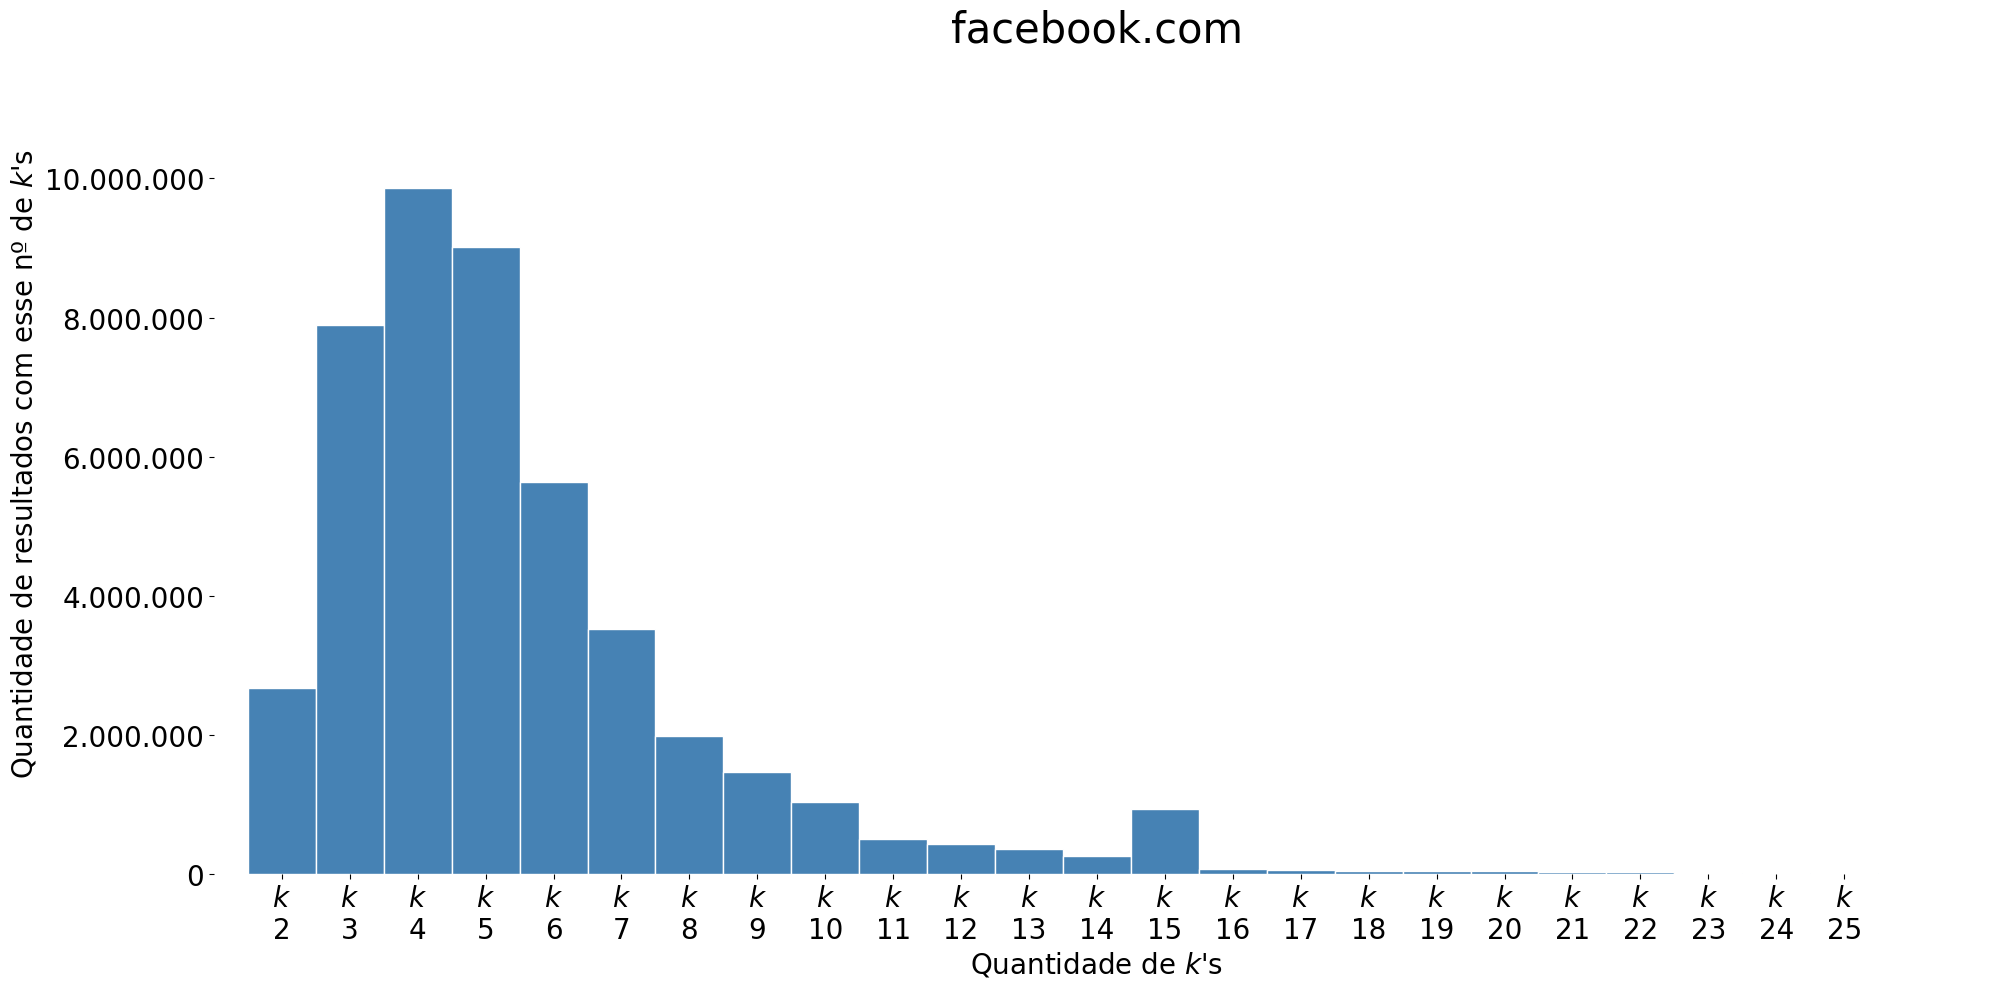

In [94]:
plot_file_2("silvia_facebook_0-25_4simul.pkl", "facebook.com", output_filename="facebook", color="steelblue")

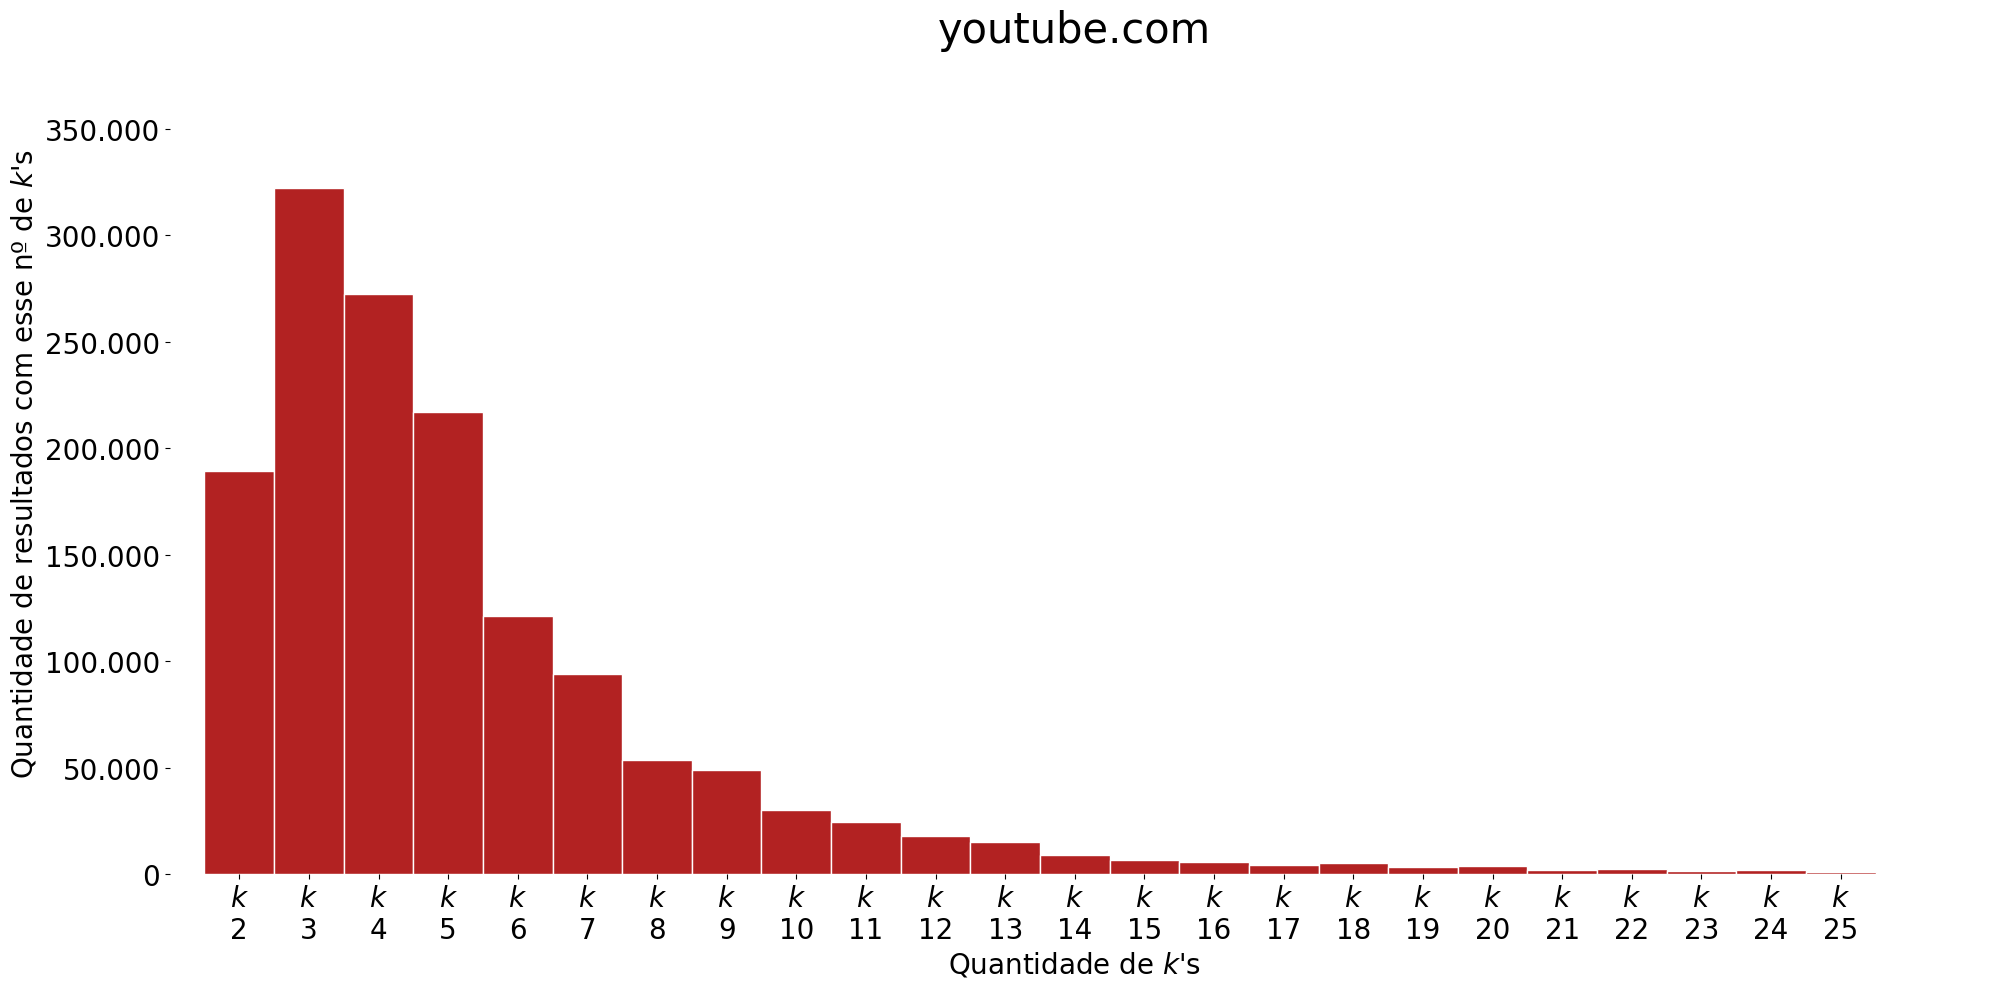

In [95]:
plot_file_2("silvia_youtube_0-25_4simul.pkl", "youtube.com", output_filename="youtube", color="firebrick")

In [25]:
np.cumsum(y[1:] / np.sum(y[1:]))

array([0.044331  , 0.13739091, 0.25437549, 0.3833224 , 0.50136247,
       0.56697939, 0.62978163, 0.67745505, 0.72935046, 0.77297779,
       0.80006896, 0.82610462, 0.85363558, 0.87019813, 0.88840551,
       0.90498565, 0.92027281, 0.93125881, 0.94101339, 0.9504777 ,
       0.95714494, 0.96310852, 0.96827167, 0.97270477, 0.97782395,
       0.98350605, 0.986567  , 0.98954   , 0.99263613, 0.99467676,
       0.99687572, 0.99851878, 1.        ])

In [26]:
str(y)

'[14500000.0, 252000.0, 529000.0, 665000.0, 733000.0, 671000.0, 373000.0, 357000.0, 271000.0, 295000.0, 248000.0, 154000.0, 148000.0, 156500.0, 94150.0, 103500.0, 94250.0, 86900.0, 62450.0, 55450.0, 53800.0, 37900.0, 33900.0, 29350.0, 25200.0, 29100.0, 32300.0, 17400.0, 16900.0, 17600.0, 11600.0, 12500.0, 9340.0, 8420.0]'